# Baggrund
De danske realkreditsobligationer er specielle og svære at prissætte, da de tillader låntageren at indfri sit lån tidligere, hvis hun ønsker det. Dette giver obligationerne optionalitet, hvilket gør dem langt sværere at prissætte sammenlignet med sædvanlige obligationer. Prisen på obligationen afhænger altså af rentestien. Vi kan derfor modellere realkreditsobligationer ved brug af Monte Carlo-simulation. Rentestien simuleres baseret på en én-faktor Hull-White-model (simplificeret – normalt bruges en generaliseret Vasicek-model). For at bestemme tilbagebetalingsraten bruger vi fordelingsfunktionen for en normalfordeling med procentgevinsten ved omlægning af lånet til den nye rente (minus omlægningsomkostninger) som input. Med denne kan vi nu, over mange rentestier, udregne de diskonterede pengestrømme og dermed samlet finde værdien af obligationen. Det er ud over denne rapports hensigt at estimere parametrene i modellen, da dette typisk involverer svært tilgængelige data, som f.eks. tilbagebetalingsadfærd. Grove vurderinger er blevet brugt efter manuel justering.



# Hull-White process af renten
For at simulere rentestien bruger vi en 1 faktor Hull-White processen. Hull-White processen opfylder følgende stokastiske differentialligning
$$
dr_t = (\theta_t-\alpha r_t)dt + \sigma dW_t
$$
Med historisk data fra renten kan vi bestemme alpha og sigma, imens vi kan bruge rentekurven fra swaps til at calibrere $\theta(t)$. For at gøre dette bruge vi Euler Maruyama med tidsskridt $h$, til at opnå 
$$
r_i = r_{i-1} + \alpha(\theta_{i}-r_{i-1})h + \sqrt{h}\sigma Z_i
$$
med $Z_i\sim N(0,1)$. 
Ved blot at køre en AR(1) model over historiske renter, kan vi dermed estimere $\alpha$ og $\sigma$. Af hensyn til dataens tilgængelighed bruger vi DESTR renten fra november 2021 til idag.


In [609]:
import QuantLib as ql
import matplotlib.pyplot as plt
import numpy as np
import numpy_financial as npf
import scipy.stats as ss
import random
import pandas as pd
from sklearn.linear_model import LinearRegression

In [662]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression


datar = pd.read_table("renter.txt")
datar["renter"] = datar["renter"].astype(float) * 0.01


datar0 = datar[:-1]
datar1 = datar[1:]


reg = LinearRegression().fit(datar0, datar1)


resid = datar1.values.flatten() - reg.predict(datar0).flatten()

stderr = np.std(resid, ddof=1)


beta = reg.coef_.item()  

a = (1 - beta) * 365
sigma = stderr * np.sqrt(365)

# Output
print(f"Estimeret Sigma: {sigma:.6f}")
print(f"Estimeret Alpha: {a:.6f}")


Estimeret Sigma: 0.012262
Estimeret Alpha: 0.737387


Vi bruger ny Quantlib til at calibrere modellen med rentestrukturen 

In [663]:
# Parameter
a = 0.7372263
sigma = 0.0122686

#tids variable
længde = 30
tidsskridt = længde*12 # måneder
renter = rates = [
    (0, 0.020667), (1, 0.0205), (2, 0.020879), (3, 0.022006), (4, 0.023196), (5, 0.024289),
    (6, 0.025137), (7, 0.025853), (8, 0.026505), (9, 0.027091),
    (10, 0.027606), (15, 0.0295), (30, 0.0282)
] # Data fra danske SWAP renter


dagsdato = ql.Date(26, 6, 2025)
rentedatoer = dates = [dagsdato + ql.Period(y, ql.Years) for y, _ in renter]
zero_curve = ql.ZeroCurve(rentedatoer, [r for _, r in renter], ql.Actual365Fixed())
curve_handle = ql.YieldTermStructureHandle(zero_curve)

hull_whiteprocess = ql.HullWhiteProcess(curve_handle, a, sigma)


# Simuleringstest
Vi laver en kort et plot over mange simulerede rentestier.

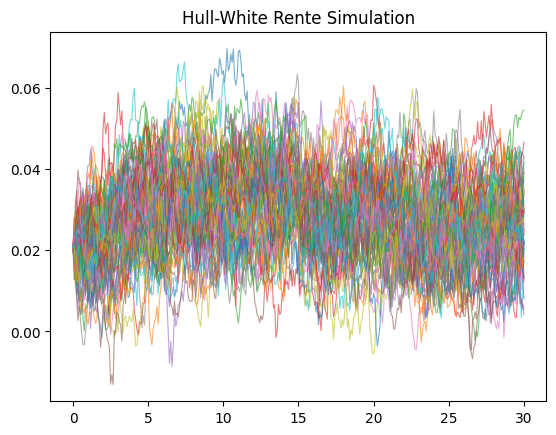

In [664]:
rng = ql.GaussianRandomSequenceGenerator(ql.UniformRandomSequenceGenerator(tidsskridt, ql.UniformRandomGenerator()))
seq = ql.GaussianPathGenerator(hull_whiteprocess, længde, tidsskridt, rng, False)
def generate_paths(num_paths, tidsskridt):
    arr = np.zeros((num_paths, tidsskridt+1))
    for i in range(num_paths):
        sample_path = seq.next()
        path = sample_path.value()
        time = [path.time(j) for j in range(len(path))]
        value = [path[j] for j in range(len(path))]
        arr[i, :] = np.array(value)
    return np.array(time), arr

num_paths = 70
time, paths = generate_paths(num_paths, tidsskridt)
for i in range(num_paths):
    plt.plot(time, paths[i, :], lw=0.8, alpha=0.6)
plt.title("Hull-White Rente Simulation")
plt.show()



# Prepayment model
Vi skal udvikle en prepayment-model for at forudsige, hvornår låntagere vil vælge at omlægge deres lån. 
Dette afhænger primært af, om de kan opnå en lavere månedlig ydelse. Her vil det være fordelagtigt at inkludere en række forskellige input (såsom makroøkonomiske variable og adfærdsbestemmende variable) og derefter anvende f.eks. gradient boosting til at opnå et præcist estimat for inputtet til fordelingsfunktionen. Vi antager at renten på den nye realkreditobligation er 100 bps højere end kort-renten.


In [717]:
my = 0.2
prepaysigma = 0.04
def forudbetalingssandsynlighed(rente, restgæld, resterende_terminer, ydelse):
    rente_m = (rente+0.01) / 12
    

    ny_ydelse = npf.pmt(rate=rente_m, nper=resterende_terminer, pv=-restgæld*(1+0.007))
    gevinst_ved_forudbetaling = ydelse / ny_ydelse - 1
    if gevinst_ved_forudbetaling < 0:
        sandsynlighed = 0  
    else:
        sandsynlighed = ss.norm.cdf(gevinst_ved_forudbetaling, 0.2, 0.04)
    return sandsynlighed

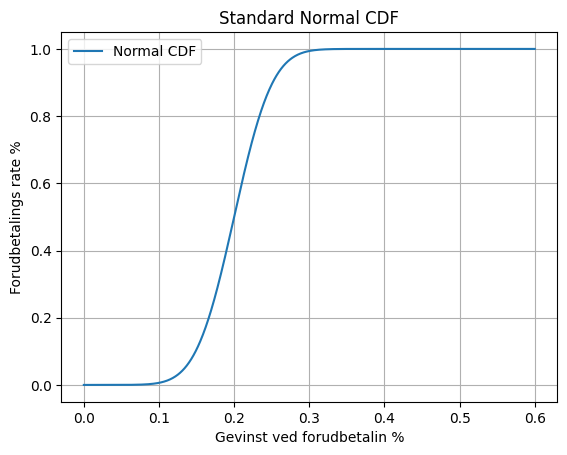

In [689]:
x = np.linspace(0, 0.6, 1000)
y = ss.norm.cdf(x, my, prepaysigma)
plt.plot(x, y, label="Normal CDF")
plt.title("Standard Normal CDF")
plt.xlabel("Gevinst ved forudbetalin %")
plt.ylabel("Forudbetalings rate %")
plt.grid(True)
plt.legend()
plt.show()

# Model
Vi har nu de nødvendige redskaber for at kunne udregne pengestrømmene over de forskellige rentestier

In [730]:
# Parametre for obligation
hovedstol = 100
kuponrente = 0.035
antal_terminer = 30 * 12
kuponrente_m = kuponrente / 12
ydelse = npf.pmt(rate=kuponrente_m, nper=antal_terminer, pv=-hovedstol)

antal_scenarier = 100
tidspunkter, rente_stier = generate_paths(antal_scenarier, tidsskridt)

npv_stier = []
afslutningstidspunkter = []

for i in range(antal_scenarier):
    rente_sti = rente_stier[i, :]
    restgæld = hovedstol
    nutidsværdi = 0
    
    for måned in range(antal_terminer+1):
        if restgæld <= 0:
            break
        
        resterende_terminer = antal_terminer - måned
        tid = (måned + 1) / 12
        indeks = min(int(tid * 12) - 1, len(rente_sti) - 1)
        rente = rente_sti[indeks]

        # Forudbetaling
        forudbetaling_sandsynlighed = forudbetalingssandsynlighed(rente, restgæld, resterende_terminer, ydelse)
        hvis_forudbetalt = np.random.rand() < forudbetaling_sandsynlighed if måned % 3 == 0 else 0

        rentebetaling = restgæld * kuponrente_m
        afdrag = ydelse - rentebetaling
        forudbetaling = hvis_forudbetalt * max(restgæld - afdrag, 0)

        samlet_afdrag = afdrag + forudbetaling
        restgæld -= samlet_afdrag

        betalingsstrøm = rentebetaling + samlet_afdrag

        integral = np.sum(rente_sti[:indeks+1]) * (1/12)
        diskonteringsfaktor = np.exp(-integral)
        nutidsværdi += diskonteringsfaktor * betalingsstrøm
    afslutningstidspunkter.append(måned)
    npv_stier.append(nutidsværdi)

print(f"Gennemsnitlig NPV: {np.mean(npv_stier):.2f}")
print(f"Standardafvigelse: {np.std(npv_stier):.2f}%")
print(f"Gennemsnitlig termin for fuld tilbagebetaling: {np.mean(afslutningstidspunkter):.2f}")


Gennemsnitlig NPV: 104.51
Standardafvigelse: 3.56%
Gennemsnitlig termin for fuld tilbagebetaling: 163.41


# Sammenligning uden forudbetaling
Vi kan bare gentage udregningen, men bare uden forudbetalingsdelen

In [732]:
# Parametre for obligation
hovedstol = 100
kuponrente = 0.035
antal_terminer = 30 * 12
kuponrente_m = kuponrente / 12
ydelse = npf.pmt(rate=kuponrente_m, nper=antal_terminer, pv=-hovedstol)

antal_scenarier = 100
tidspunkter, rente_stier = generate_paths(antal_scenarier, tidsskridt)

npv_stier = []
afslutningstidspunkter = []

for i in range(antal_scenarier):
    rente_sti = rente_stier[i, :]
    restgæld = hovedstol
    nutidsværdi = 0
    
    for måned in range(antal_terminer+1):
        if restgæld <= 0:
            break
        
        resterende_terminer = antal_terminer - måned
        tid = (måned + 1) / 12
        indeks = min(int(tid * 12) - 1, len(rente_sti) - 1)
        rente = rente_sti[indeks]


        forudbetaling_sandsynlighed = 0 # Uden forudbetaling
        hvis_forudbetalt = np.random.rand() < forudbetaling_sandsynlighed if måned % 3 == 0 else 0

        rentebetaling = restgæld * kuponrente_m
        afdrag = ydelse - rentebetaling
        forudbetaling = hvis_forudbetalt * max(restgæld - afdrag, 0)

        samlet_afdrag = afdrag + forudbetaling
        restgæld -= samlet_afdrag

        betalingsstrøm = rentebetaling + samlet_afdrag

        integral = np.sum(rente_sti[:indeks+1]) * (1/12)
        diskonteringsfaktor = np.exp(-integral)
        nutidsværdi += diskonteringsfaktor * betalingsstrøm
    afslutningstidspunkter.append(måned)
    npv_stier.append(nutidsværdi)


print(f"Gennemsnitlig NPV: {np.mean(npv_stier):.2f}")
print(f"Standardafvigelse: {np.std(npv_stier):.2f}%")
print(f"Gennemsnitlig termin for fuld tilbagebetaling: {np.mean(afslutningstidspunkter):.2f}")


Gennemsnitlig NPV: 108.64
Standardafvigelse: 4.31%
Gennemsnitlig termin for fuld tilbagebetaling: 360.00


# Konklusion

Vi ser at vi få en langt lavere værdi $108.64-104.51\approx 4$, når vi modellerer for forudbetalingsrisiko. Dog er vi stadig et godt
stykke fra markedsværdi. En realkreditobligation 3,5% 2056 med afdrag er åben for tilbud på 95,55.
Samlet set skyldes dette antageligt problemer med den underliggende rentemodel og
modelleringen af tilbagebetalingsrisiko. Modellen viser de underliggende ideer bag ved prissætning
af realkreditobligationer, men er stadig langt fra markedspriser.
